## PROJECT 24: SkimLit 

> ### TASK: Create an NLP model to classify abstract sentences into the role they play (e.g. objective, methods, results, etc) to enable researchers to skim through the literature (hence SkimLit) and dive deeper when necessary.


### Project goals and objectives

#### Project goal

- Studying **ANN model for sequential sentence classification**

#### Project objectives

1. [x] Explore and prepare data 
1. [x] TF-IDF classifier
2. [x] Conv1D with token embeddings
3. [ ] Feature extraction with pretrained token embeddings
4. [ ] Conv1D with character embeddings
5. [ ] Combining pretrained token embeddings + character embeddings (hybrid embedding layer
6. [ ] Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings


### IMPORT LIBRARIES

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('dark')
import random
import string

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, GlobalMaxPool1D, Dropout, Dense,GlobalAveragePooling1D, Input, Embedding, MaxPool1D, Flatten
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

import tensorflow_hub as hub

from helper_functions import calculate_results

In [2]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2060 (UUID: GPU-9dc3685b-6a88-c130-be43-7b38ad2c7abc)


### GET DATA

In [3]:
# Copy data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
# Check files in the dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [5]:
# Path to data
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# Check all of the filenames in the target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

### DATA PREPROCESSING

In [7]:
# Read the lines of a document
def get_lines(filename):
    with open(filename, "r") as f:
        return f.readlines()

In [8]:
# Read train data 
train_lines = get_lines(data_dir + "train.txt")
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
# A list of dictionaries of abstract line data

def preprocess_text_with_line_numbers(filename):
    
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [10]:
# Preprocess data 
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") 
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [11]:
# Check result
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [12]:
# Create dataframe
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [13]:
train_df.head(3)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11


In [14]:
val_df.head(3)

,target,text,line_number,total_lines
0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,0,9
1,BACKGROUND,it is not clear whether these patients would b...,1,9
2,OBJECTIVE,we sought to determine whether a @-month cours...,2,9


In [15]:
test_df.head(3)

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8


### EXPLORATORY DATA ANALISIS

In [16]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

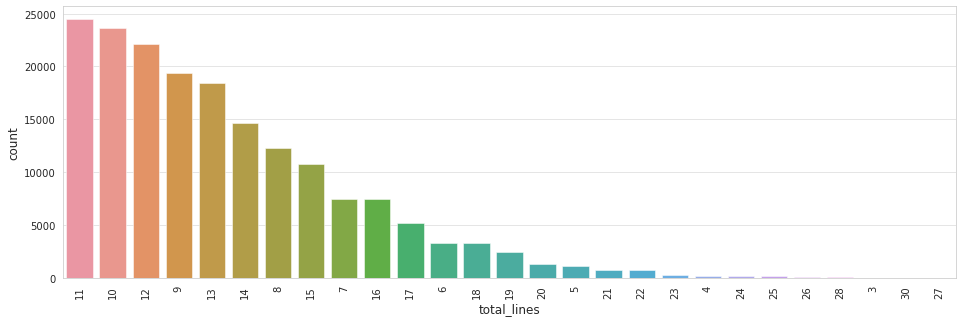

In [17]:
plt.figure(figsize=(16,5))
plt.xticks(rotation=90)
ax= sns.countplot(x='total_lines', data= train_df, order = train_df['total_lines'].value_counts().index)

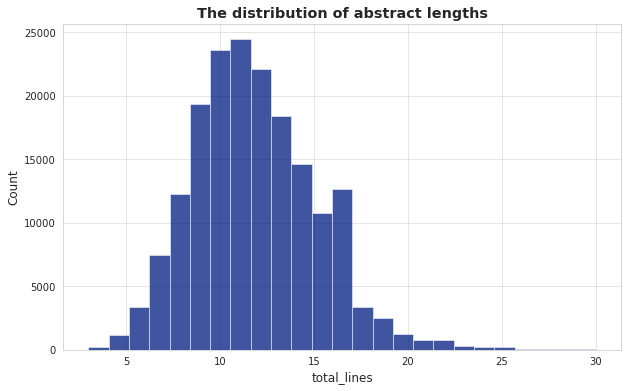

In [18]:
#Distribution of number of abstract lengths
plt.figure(figsize=(10,6))
sns.histplot(data=train_df["total_lines"], bins=25)
plt.title('The distribution of abstract lengths',fontweight="bold")
plt.show()

<AxesSubplot:xlabel='total_lines', ylabel='count'>

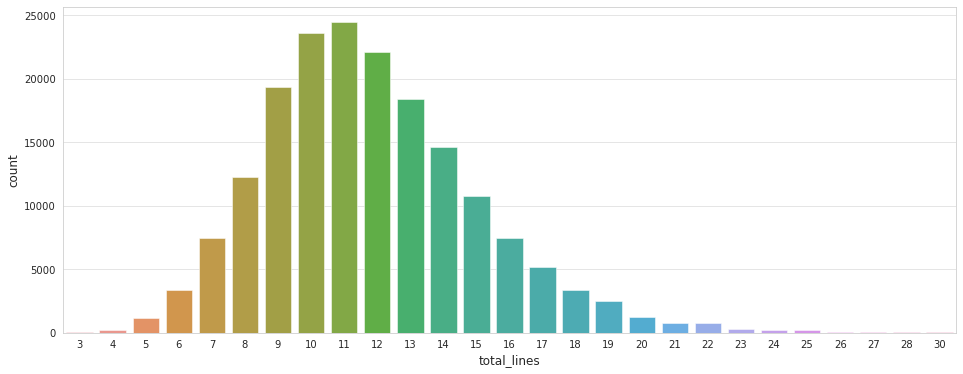

In [19]:
plt.figure(figsize=(16,6))
sns.countplot(x='total_lines', data= train_df)

In [20]:
# Get lists of sentences
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [21]:
# Example of training sentences
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [22]:
# Average sentence length
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

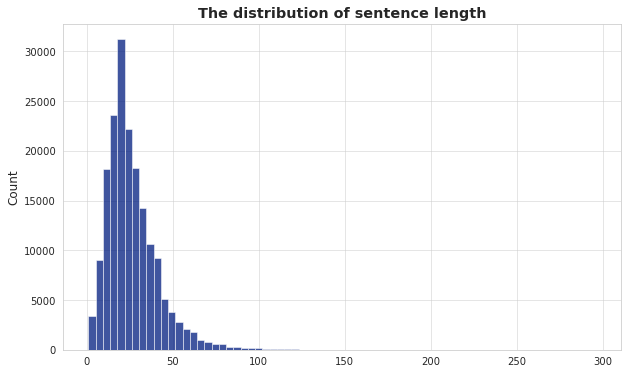

In [23]:
#Distribution of number of sentence length
plt.figure(figsize=(10,6))
sns.histplot(data=sent_lens, bins=70)
plt.title('The distribution of sentence length',fontweight="bold")
plt.show()

In [24]:
# Length of a sentence covers 95% of the lengths
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [25]:
# Maximum sentence length in the training set
max(sent_lens)

296

### CREATE A NUMERIC LABELS 

In [26]:
# One hot encode labels
one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

In [27]:
# Check result
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [28]:
# Label encode labels
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [29]:
# Check result
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [30]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## TF-IDF MULTINOMIAL NAIVE BAYES

In [31]:
# Create a pipeline
model_0 = Pipeline([("tf-idf", TfidfVectorizer()),
                    ("clf", MultinomialNB())])

In [32]:
# Fit the pipeline to the training data
model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

In [33]:
# Predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [34]:
# Baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## CONV1D WITH TOKEN EMBEDDINGS

### Text vectorizer

In [35]:
max_tokens = 68000

In [36]:
# Text vectorizer
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=55)

2021-10-28 21:51:25.277495: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 21:51:25.286721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 21:51:25.287631: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 21:51:25.289232: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [37]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

2021-10-28 21:51:26.862639: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [38]:
# Check result 
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
the analysis was based on @ returned questionnaires ( @ % ) with a self-sample specimen , and @ ( @ % ) without .

Length of text: 25

Vectorized text:
[[    2    85    10   261    18  2604   913     7     8 28602  5323     3
    159     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


### Text embedding

In [39]:
# Number of words in vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}")

Number of words in vocabulary: 64841


In [40]:
# Token embedding layer
token_embed = Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=256, 
                               mask_zero=True,
                               name="token_embedding") 

In [41]:
# Example of embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
the analysis was based on @ returned questionnaires ( @ % ) with a self-sample specimen , and @ ( @ % ) without .

Sentence after vectorization (before embedding):
[[    2    85    10   261    18  2604   913     7     8 28602  5323     3
    159     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.04894903 -0.02958405  0.01835967 ...  0.04834911 -0.03035229
    0.03008856]
  [ 0.02910967 -0.03161726  0.02516422 ... -0.02178756  0.0166744
   -0.04171804]
  [ 0.02563795 -0.01450126 -0.04750457 ... -0.02106292 -0.00138781
    0.0359041 ]
  ...
  [ 0.02453857 -0.00755722  0.02939925 ... -0.01124829 -0.01413442
   -0.01514461]
  [ 0.02453857 -0.00755722  0.02939925 ... -0.01124829 -0.01413442
   -0.01514461]
  [ 0.02453857 -

### Datasets

In [42]:
# Turn data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [43]:
# Turn the TensorSliceDataset's into prefetched batches
train_dataset = train_dataset.batch(512).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(512).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(512).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

### Model 1: Conv1D with token embeddings

In [44]:
# 1D convolutional model to process sequences
inputs = Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = Conv1D(filters=64, kernel_size=3, padding="same", activation="relu")(token_embeddings)
x = Conv1D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
x = MaxPool1D(pool_size=2)(x)

x = Conv1D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
x = Conv1D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
x = MaxPool1D(pool_size=2)(x)

x = Conv1D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
x = Conv1D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
x = MaxPool1D(pool_size=2)(x)

x = Conv1D(filters=512, kernel_size=3, padding="same", activation="relu")(x)
x = Conv1D(filters=512, kernel_size=3, padding="same", activation="relu")(x)


x = GlobalAveragePooling1D()(x)

outputs = Dense(num_classes, activation="softmax")(x)

model_1 = Model(inputs, outputs)

In [45]:
# Compile model
model_1.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 256)           16599296  
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            49216     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 55, 64)            12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 27, 128)           24704 

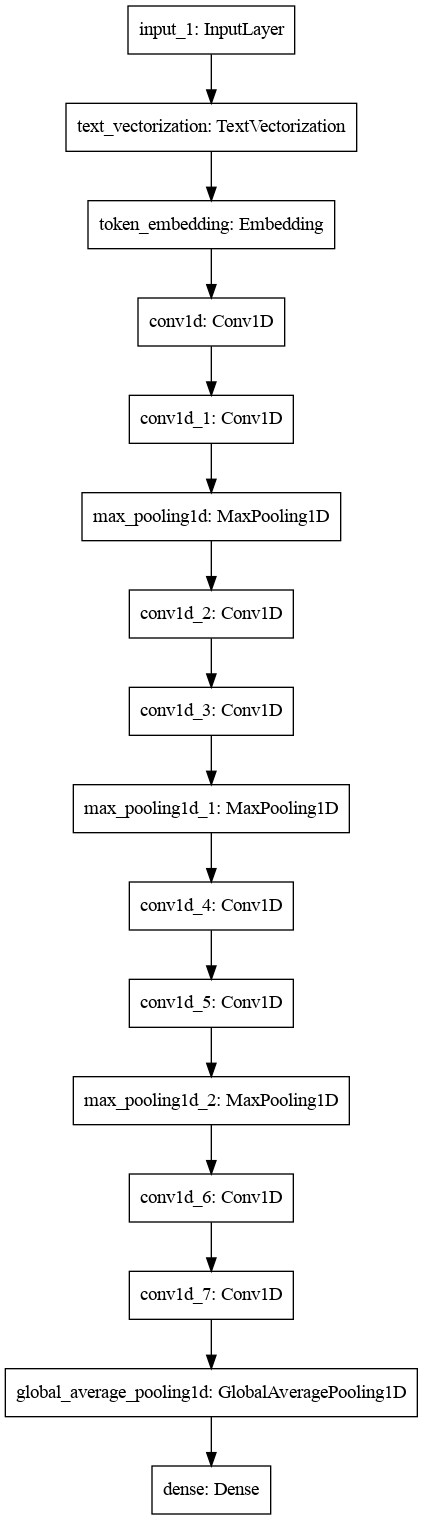

In [46]:
# Get summary of Conv1D model
model_1.summary()
tf.keras.utils.plot_model(model_1, to_file='Model_1_Conv1D_with_token_embeddings.png')

In [47]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              epochs=20,
                              validation_data=valid_dataset)

Epoch 1/20


2021-10-28 21:51:40.460324: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204
2021-10-28 21:51:40.905752: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


352/352 [==============================] - 19s 45ms/step - loss: 0.8069 - accuracy: 0.6554 - val_loss: 0.5155 - val_accuracy: 0.8083
Epoch 2/20
352/352 [==============================] - 15s 42ms/step - loss: 0.4550 - accuracy: 0.8338 - val_loss: 0.5129 - val_accuracy: 0.8145
Epoch 3/20
352/352 [==============================] - 15s 42ms/step - loss: 0.3569 - accuracy: 0.8726 - val_loss: 0.6078 - val_accuracy: 0.8049
Epoch 4/20
352/352 [==============================] - 15s 42ms/step - loss: 0.2963 - accuracy: 0.8937 - val_loss: 0.6493 - val_accuracy: 0.7968
Epoch 5/20
352/352 [==============================] - 15s 42ms/step - loss: 0.2353 - accuracy: 0.9171 - val_loss: 0.7755 - val_accuracy: 0.7825
Epoch 6/20
352/352 [==============================] - 16s 45ms/step - loss: 0.1992 - accuracy: 0.9309 - val_loss: 0.7761 - val_accuracy: 0.7942
Epoch 7/20
352/352 [==============================] - 16s 46ms/step - loss: 0.1755 - accuracy: 0.9397 - val_loss: 0.8339 - val_accuracy: 0.7985
Epo

#### EVALUATION RESULT

In [48]:
def learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(20, 8))
    plt.grid(True)
    plt.title('Learning curves')
    plt.gca().set_ylim(0, 1)
    plt.show()


def evaluation_model(history):
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(20, 8))
    axL.plot(history.history['loss'], label="Training loss")
    axL.plot(history.history['val_loss'], label="Validation loss")
    axL.set_title('Training and Validation loss')
    axL.set_xlabel('Epochs')
    axL.set_ylabel('Loss')
    axL.legend(loc='upper right')

    axR.plot(history.history['accuracy'], label="Training accuracy")
    axR.plot(history.history['val_accuracy'], label="Validation accuracy")
    axR.set_title('Training and Validation accuracy')
    axR.set_xlabel('Epoch')
    axR.set_ylabel('Accuracy')
    axR.legend(loc='upper right')

    plt.show()

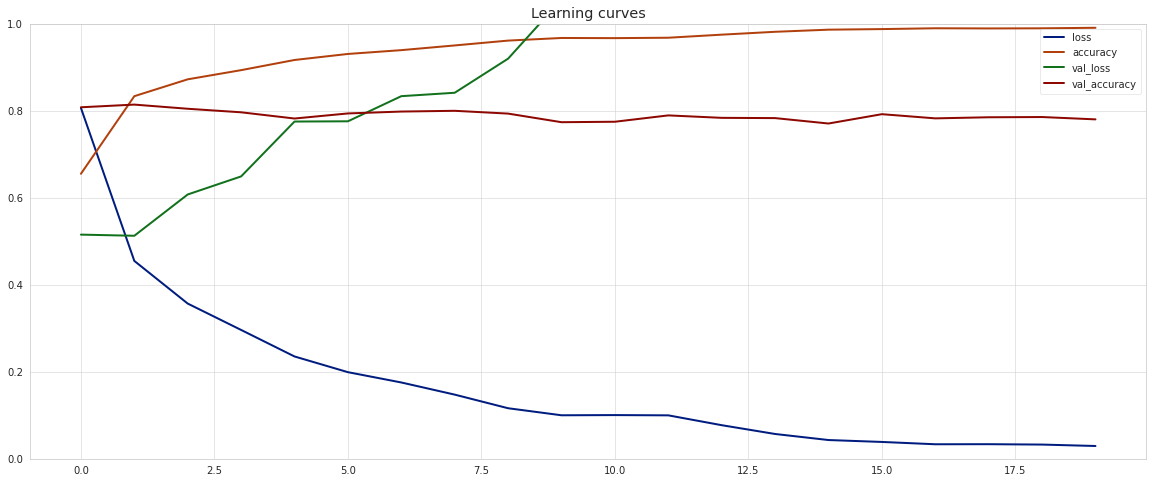

In [49]:
# Learning curves
learning_curves(model_1_history)

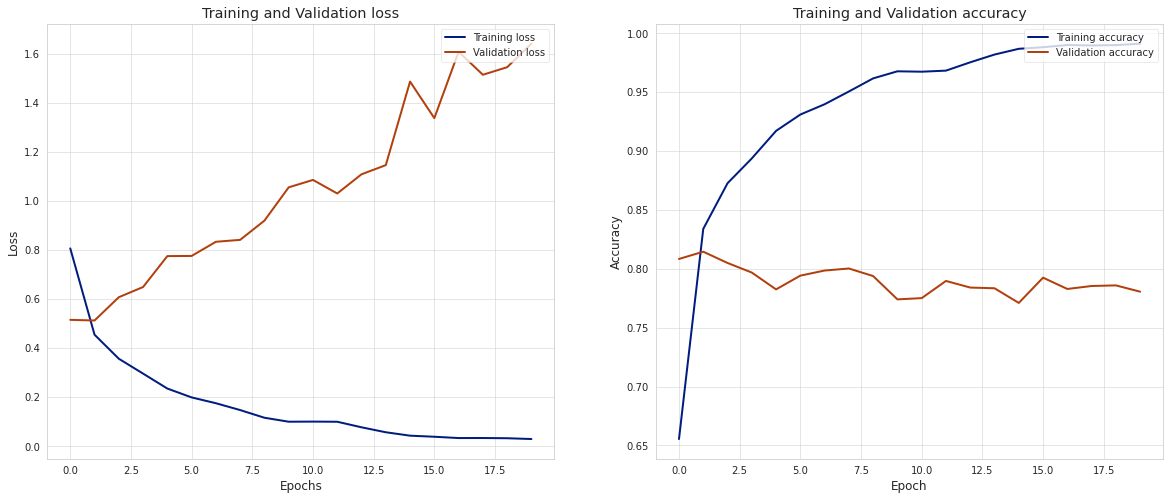

In [50]:
# Evaluation model
evaluation_model(model_1_history)

In [51]:
# Evaluate the results
model_1.evaluate(valid_dataset)

60/60 [==============================] - 1s 16ms/step - loss: 1.6417 - accuracy: 0.7805


[1.64173424243927, 0.7805176973342896]

In [52]:
# Predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[3.95104568e-03, 3.18145976e-05, 4.22463454e-02, 9.53709781e-01,
        6.10792849e-05],
       [1.01651400e-02, 6.09764372e-09, 5.85574867e-07, 9.89834309e-01,
        5.16128633e-11],
       [1.20911755e-01, 1.02511263e-10, 1.62994493e-05, 8.79071951e-01,
        2.03258677e-11],
       ...,
       [3.64481623e-09, 9.81149100e-08, 1.28908505e-05, 7.43253861e-11,
        9.99987006e-01],
       [3.45304422e-03, 8.12768579e-01, 6.41942490e-04, 3.62097198e-04,
        1.82774305e-01],
       [4.98749708e-10, 1.00000000e+00, 4.25622870e-11, 8.65296446e-11,
        9.39579525e-09]], dtype=float32)

In [53]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 3, 3, ..., 4, 1, 1])>

In [54]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.05176750959883,
 'precision': 0.7867098305761318,
 'recall': 0.7805176750959884,
 'f1': 0.7817299578520043}

In [55]:
# Save model 
model_1.save("Model_1_Conv1D_with_token_embeddings")

2021-10-28 21:56:50.562533: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Model_1_Conv1D_with_token_embeddings/assets
